In [1]:
import gurobipy as gp
from gurobipy import *
import geopy.distance

In [2]:

import numpy as np
from numpy import loadtxt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import time
from heapq import nsmallest

In [3]:
df_csv = pd.read_csv('  ') # Set up data


,Index,demand,prob_fail,fixed cost,lat,lon
0,0,732.2564,0.001,100000,40.67054,73.94548
1,1,348.5398,0.004,100000,34.11210,118.41120
2,2,278.3726,0.023,100000,41.83705,87.68497
3,3,163.0553,0.002,100000,29.76805,95.38733
4,4,158.5577,0.020,100000,40.00682,75.13468


In [4]:
def lat_lon_distmatrix(df_csv):
    dist = np.zeros((length,length+1)) #Plus emergency 
    df = pd. DataFrame(df_csv[['lat','lon']])
    records = df.to_records(index=False)
    result = list(records)
    for i in range(len(result)):
        for j in range(len(result)):
            dist[i,j] = geopy.distance.distance(result[i], result[j]).km*0.621371
    return dist
def euc_distmatrix(df_csv):
    dist = np.zeros((length,length+1)) #Plus emergency 
    df = pd. DataFrame(df_csv[['lat','lon']])
    records = df.to_records(index=False)
    result = list(records)
    for i in range(len(result)):
        for j in range(len(result)):
            dist[i,j] = math.sqrt( (result[i][0]- result[j][0])**2 + (result[i][1]- result[j][1])**2)
    return dist
    
length = df_csv.shape[0]
c_ij = lat_lon_distmatrix(df_csv)*(10**(-5))
#c_ij = euc_distmatrix(df_csv)*(10**(-3))
c_ij[:,length] = c_ij[:,length]+0.1  #Emergency cost

In [5]:
V_1 = [i for i in range(0, length)] # Customer
V_2 = [i for i in range(0, length+1)] # Facility + emergency
S = [i for i in range(0, 10)] #Scenarios
T = [i for i in range(1, 5)] #Time 4 period 
TE = [i for i in range(0, 5)] # include period 0

d_i = list(df_csv['demand']*10000)

f_j = list(df_csv['fixed cost']) 

A = [(i, j, t, s) for i in V_1 for j in V_2 for t in T for s in S ]
A_1 = [(i, j, t, s) for i in V_1 for j in V_2[:-1] for t in T for s in S ]

E = [(i, j) for i in V_1 for j in V_2 ]


o = 3000
c = 3000
jt = [(j, t) for j in V_2 for t in T]

q_jt = np.zeros((len(V_1)+1,4))
info = [1,2,4,8]
for i in range(0,4):
    q_jt[:,i] = list(df_csv['prob_fail'] *(info[i])) + [0] #Prob_fail + Emergency facility
    # (i+1)*0.25


for i in V_1:
    #if i not in idx_fix:      
    f_j[i] =  f_j[i]/10

In [49]:
def rank_risk(V_1 ,q_jt, N = 20, t = 3): # Number of decision var.
    idx = list(np.argsort(q_jt[:,t])[:N])
    return idx  
###################################################################
N = 2 # adjust N number to satisfy percent area coverage
idx_set = rank_risk(V_1 ,q_jt, N , t = 1)
###################################################################
idx_set = list(set(idx_x).union(set(idx_set))) #include initial
idx_set.sort(reverse=1)

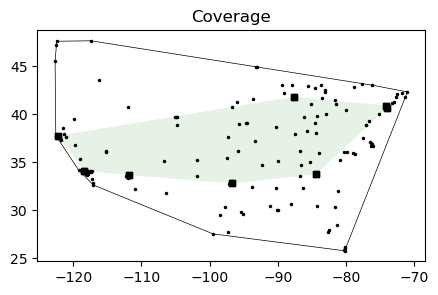

Percent coverage: 80.0246210823978%
Total union set: [136, 121, 37, 34, 7, 2, 1, 0]
8


In [51]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import numpy as np

###Generate point for plot###
#points = np.array(list(zip(df_csv['lon'], df_csv['lat'])))  # Random points in 2-D
points = []
for i in idx_set[1:]: #no cutting , cut 88
    points.append([ list(df_csv['lon'])[i]*(-1) , list(df_csv['lat'])[i] ])
points = np.array(points)

full_points = np.array(list(zip(list(df_csv['lon']*(-1)), list(df_csv['lat']))))
#############################


hull = ConvexHull(points)
hull_full = ConvexHull(full_points)

#fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))
fig,  ax2 = plt.subplots(ncols=1, figsize=(5, 3))

for ax in  [ax2]: ####(ax1, ax2)
    ax.plot(points[:, 0], points[:, 1], 's', color='k', ms = 5)
    ax.plot(full_points[:, 0], full_points[:, 1], '.', color='k', ms = 3)
    

    ax.set_title('Coverage')
    '''for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], 'g', lw = 0.5)'''
    for simplex in hull_full.simplices:
        ax.plot(full_points[simplex, 0], full_points[simplex, 1], 'k', lw = 0.5)

    ax.plot(points[hull.vertices, 0], points[hull.vertices, 1], 's', mec='k', color='none', lw=1, markersize=5)

    #Fill the area within the lines that we have drawn
    ax.fill(points[hull.vertices,0], points[hull.vertices,1], 'g', alpha=0.1)
    
plt.show()

print("Percent coverage: {}%".format(hull.area*100/hull_full.area))
total_set = idx_set[1:]
print("Total union set: {}".format(total_set))
print(len(total_set))

# Plot pareto

In [21]:
x=[]
per_cover = []
full_points = np.array(list(zip(list(df_csv['lon']), list(df_csv['lat']))))
hull_full = ConvexHull(full_points)
for i in range(0,91):#more than 3 node to calculate area
    idx_set = rank_risk(V_1 ,q_jt, N = i, t = 3)
    # Include initial
    idx_set = list(set(idx_x).union(set(idx_set))) #include initial
    idx_set.sort(reverse=1)
    
    points = []
    for i in idx_set[1:]:
        points.append([ list(df_csv['lon'])[i] , list(df_csv['lat'])[i] ])
    points = np.array(points)
    hull = ConvexHull(points)
    
    
    per_cover.append(hull.area/hull_full.area)
    x.append(points.shape[0])
per_cover = [0,0]+per_cover
x = [0,0]+x

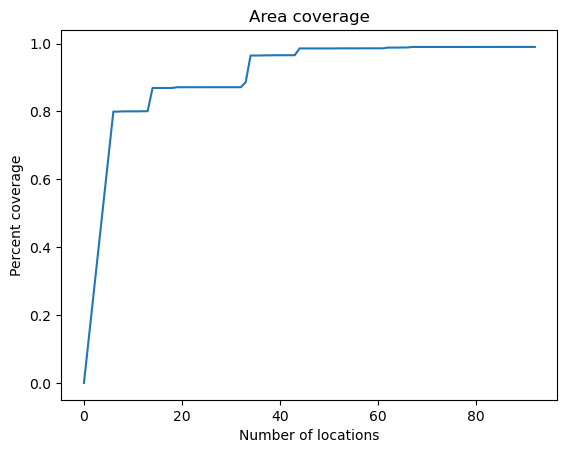

In [22]:

y = per_cover

plt.plot(x, y)
plt.title('Area coverage')
plt.xlabel('Number of locations')
plt.ylabel('Percent coverage')
plt.show()

In [23]:
dict(zip(x, y))

{0: 0,
 6: 0.7995200718077725,
 7: 0.7995207285637465,
 8: 0.8002462108239781,
 9: 0.8002462108239781,
 10: 0.8002462108239781,
 11: 0.8002751468070909,
 12: 0.8006517779483977,
 13: 0.8006517779483977,
 14: 0.869177061906264,
 15: 0.869177061906264,
 16: 0.869177061906264,
 17: 0.869177061906264,
 18: 0.869177061906264,
 19: 0.8713844298845967,
 20: 0.8713844298845967,
 21: 0.8713844298845967,
 22: 0.8713844298845967,
 23: 0.8713844298845967,
 24: 0.8713844298845967,
 25: 0.8713844298845967,
 26: 0.8713844298845967,
 27: 0.8713988165290512,
 28: 0.8713988165290512,
 29: 0.8713988165290512,
 30: 0.8713988165290512,
 31: 0.8713988165290512,
 32: 0.8713988165290512,
 33: 0.8860224163241341,
 34: 0.9648467583480519,
 35: 0.9648467583480519,
 36: 0.9648467583480519,
 37: 0.9653392428707399,
 38: 0.9653392428707399,
 39: 0.9656501990667424,
 40: 0.9656501990667424,
 41: 0.9656501990667424,
 42: 0.965686831940186,
 43: 0.965686831940186,
 44: 0.9856776160445384,
 45: 0.9856776160445384,
 46:

# 